In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [36]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['p']
titles= ['p']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_ssim_pseperate'

In [4]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [37]:

df = np.empty((0,66,256,7))
df_label = np.empty((0,66,256,7))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


In [5]:
n=[3]
df_label=df_label[:,:,:,n]
df=df[:,:,:,n]


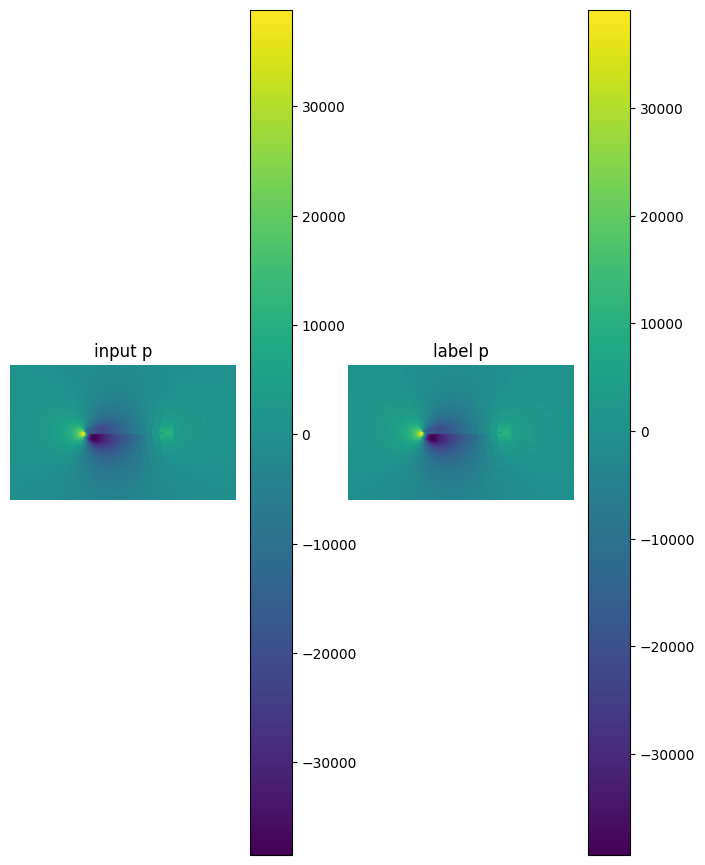

In [6]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

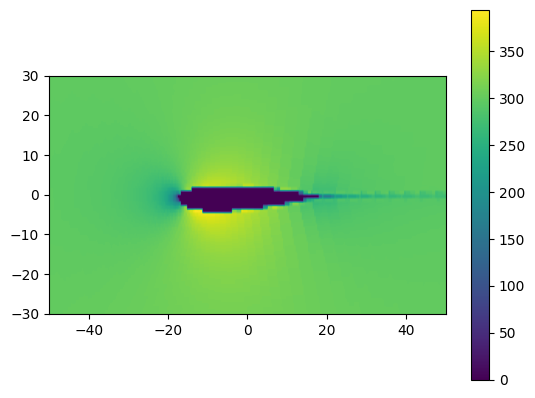

In [6]:
plt.imshow(df[1000,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.colorbar()

In [7]:
df_label[n,:,:,3].shape

(66, 256)

In [39]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
#normal=np.array([p_max]).reshape(1,1,1,1)
normal=np.array([U_max,U_max,U_max, p_max,k_max, omega_max,nut_max]).reshape(1,1,1,7)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


[[[[4.41323047e+03 4.41323047e+03 4.41323047e+03 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]


In [8]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

p



In [10]:
df1=df*1/normal
df_label1=df_label/normal

IndexError: index 3 is out of bounds for axis 3 with size 1

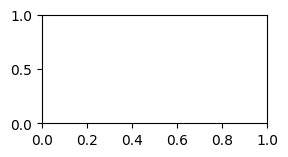

In [11]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [12]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

In [13]:
ylim[1]

30

20


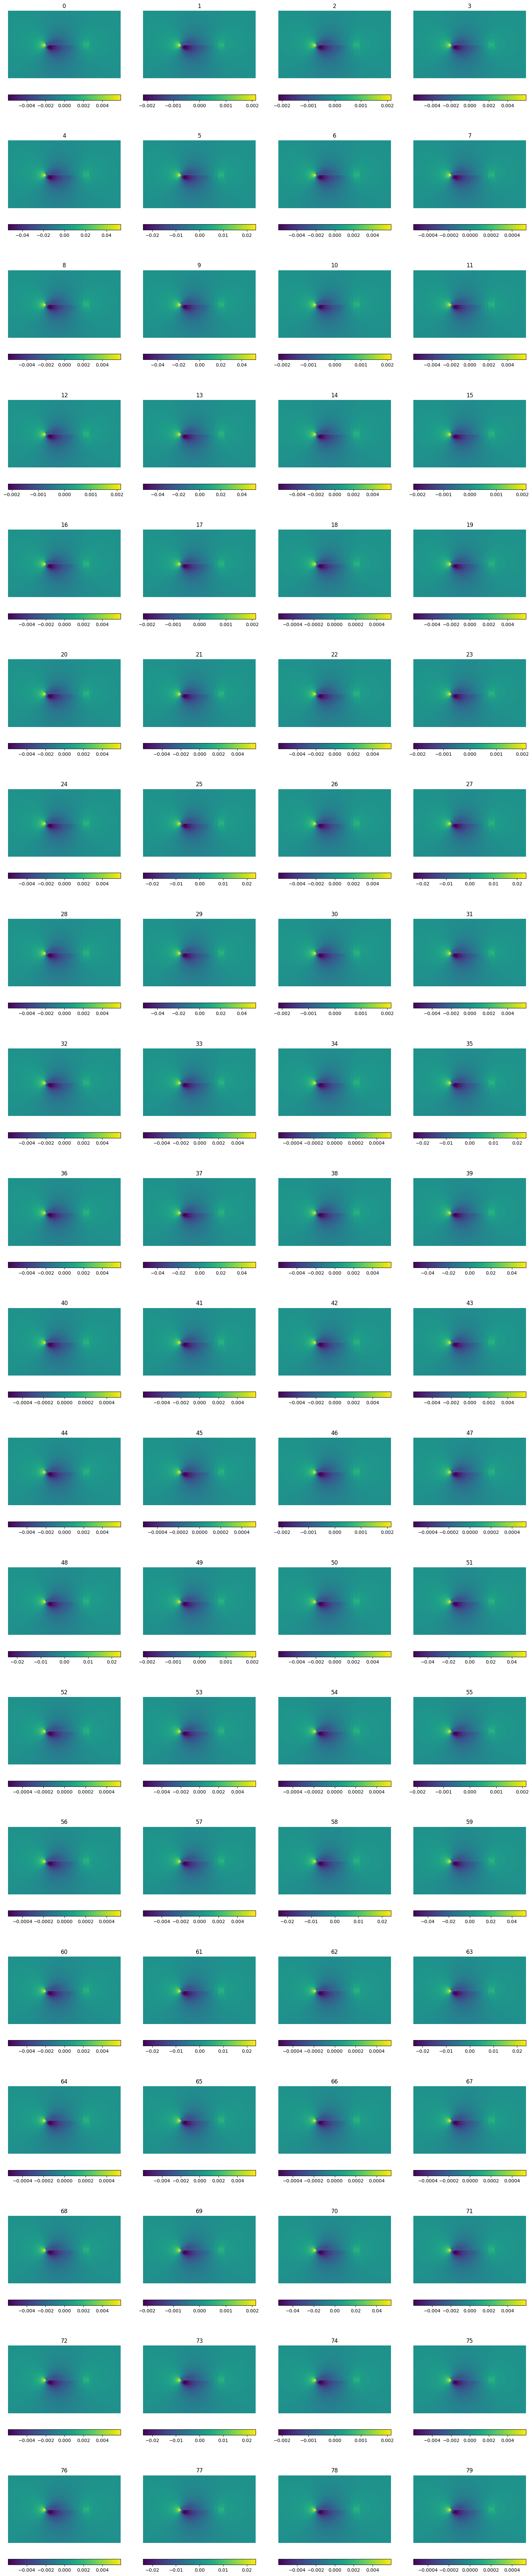

In [16]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [17]:
[a,b,c,d]=df.shape

In [18]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='PReLU', padding="same"))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        784       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 1)       1

In [20]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [21]:
model.compile(optimizer='adam',
              loss=SSIMLoss)

In [22]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_10', 'training_11', 'training_12', 'training_13', 'training_14', 'training_15', 'training_16', 'training_17', 'training_18', 'training_19', 'training_2', 'training_20', 'training_21', 'training_22', 'training_23', 'training_24', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7', 'training_8', 'training_9']
training_25


In [23]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [24]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0309
Epoch 1: loss improved from inf to 0.03085, saving model to training/training_25\vae_best_model_relu.epoch01-loss0.03085.w
61/61 [==============================] - 45s 716ms/step - loss: 0.0309 - val_loss: 0.0133
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.0112
Epoch 2: loss improved from 0.03085 to 0.01115, saving model to training/training_25\vae_best_model_relu.epoch02-loss0.01115.w
61/61 [==============================] - 43s 705ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.0078
Epoch 3: loss improved from 0.01115 to 0.00785, saving model to training/training_25\vae_best_model_relu.epoch03-loss0.00785.w
61/61 [==============================] - 43s 712ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 0.0106
Epoch 4: loss did not improve from 0.00785
61/61 

61/61 [==============================] - 45s 732ms/step - loss: 6.1245e-04 - val_loss: 4.9507e-04
Epoch 35/100
61/61 [==============================] - ETA: 0s - loss: 5.2135e-04
Epoch 35: loss improved from 0.00061 to 0.00052, saving model to training/training_25\vae_best_model_relu.epoch35-loss0.00052.w
61/61 [==============================] - 44s 717ms/step - loss: 5.2135e-04 - val_loss: 3.4582e-04
Epoch 36/100
61/61 [==============================] - ETA: 0s - loss: 5.5952e-04
Epoch 36: loss did not improve from 0.00052
61/61 [==============================] - 44s 714ms/step - loss: 5.5952e-04 - val_loss: 3.3978e-04
Epoch 37/100
61/61 [==============================] - ETA: 0s - loss: 4.8949e-04
Epoch 37: loss improved from 0.00052 to 0.00049, saving model to training/training_25\vae_best_model_relu.epoch37-loss0.00049.w
61/61 [==============================] - 45s 738ms/step - loss: 4.8949e-04 - val_loss: 4.7506e-04
Epoch 38/100
61/61 [==============================] - ETA: 0s - l

61/61 [==============================] - ETA: 0s - loss: 5.7711e-04
Epoch 70: loss did not improve from 0.00041
61/61 [==============================] - 44s 721ms/step - loss: 5.7711e-04 - val_loss: 6.0693e-04
Epoch 71/100
61/61 [==============================] - ETA: 0s - loss: 4.6292e-04
Epoch 71: loss did not improve from 0.00041
61/61 [==============================] - 45s 735ms/step - loss: 4.6292e-04 - val_loss: 5.3680e-04
Epoch 72/100
61/61 [==============================] - ETA: 0s - loss: 4.5218e-04
Epoch 72: loss did not improve from 0.00041
61/61 [==============================] - 45s 731ms/step - loss: 4.5218e-04 - val_loss: 5.2287e-04
Epoch 73/100
61/61 [==============================] - ETA: 0s - loss: 4.8056e-04
Epoch 73: loss did not improve from 0.00041
61/61 [==============================] - 44s 719ms/step - loss: 4.8056e-04 - val_loss: 7.0908e-04
Epoch 74/100
61/61 [==============================] - ETA: 0s - loss: 4.3406e-04
Epoch 74: loss did not improve from 0.00

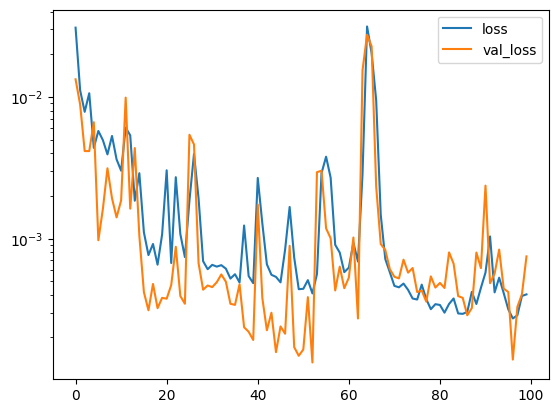

In [25]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [26]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

97
vae_best_model_relu.epoch97-loss0.00027.w


In [27]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_25/vae_best_model_relu.epoch97-loss0.00027.w


In [28]:
test=model.predict(test_data)

11/11 [==============================] - 1s 36ms/step


In [29]:
print(label_test.shape[0])
n=5
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345


IndexError: index 5 is out of bounds for axis 3 with size 1

(345, 66, 256, 1)


IndexError: index 3 is out of bounds for axis 3 with size 1

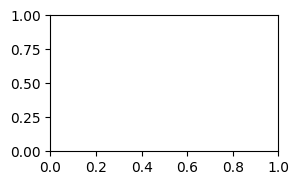

In [30]:
print(test_data.shape)
n=23
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')


plt.show()

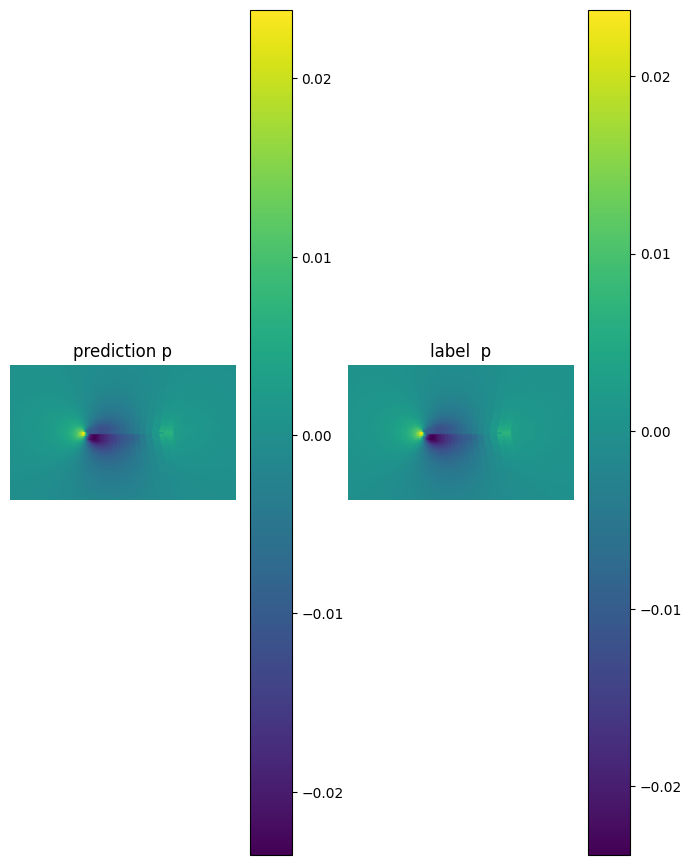

In [31]:
n=23
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
#titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

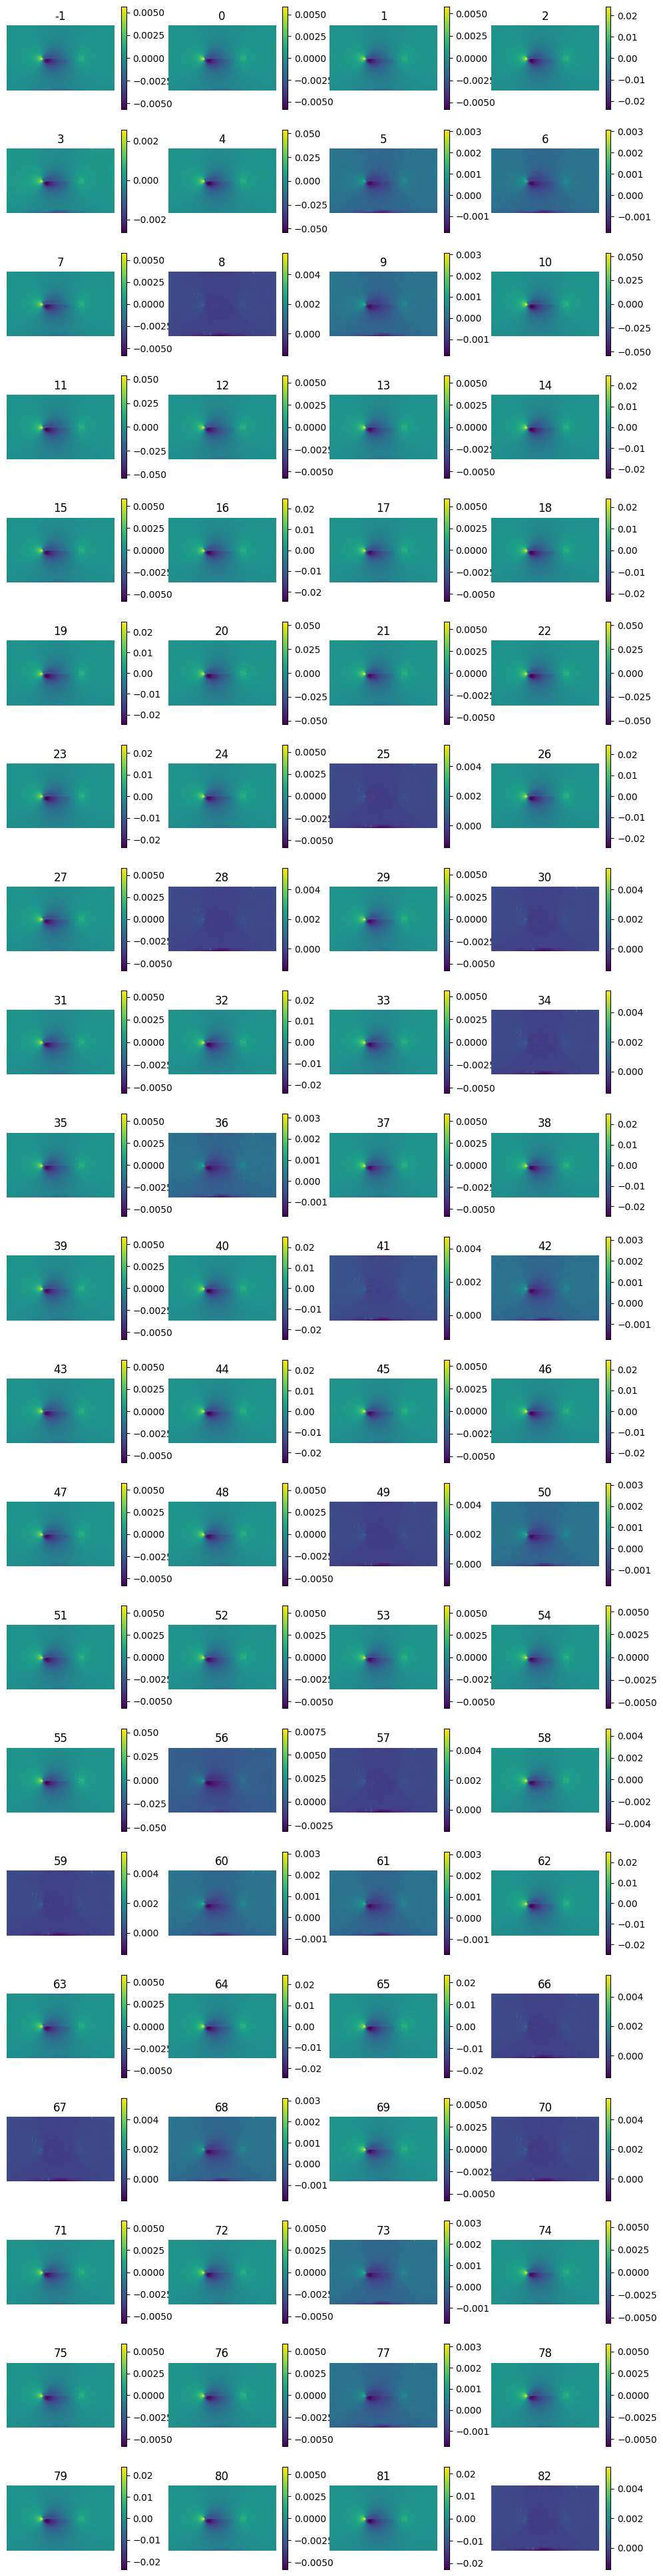

In [32]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

In [34]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:2.0362468937169448e-07
0.9999409326314926
3.556620590069448e-08
average ssim: 0.9999249527716751
average mse: 6.725774283211873e-08


In [34]:
#os.mkdir('cfdnetplus_models')
model.save(model_path)

INFO:tensorflow:Assets written to: cfdnetplus_models/model_ssim_pseperate/assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_ssim_pseperate/assets


In [33]:
print(model_path)

cfdnetplus_models/model_ssim_pseperate/


In [41]:
model_path='cfdnetplus_models/'+modelid+'/'